<a href="https://colab.research.google.com/github/chaudharyajit/Thesis/blob/main/Archive_Multi_Kernel_CNN_Imbalance_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jan 26 07:48:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change directory
import os
os.chdir("/content/drive/MyDrive/data")

try:
  os.mkdir("Multi-Class")
except:
  print('Folder Already Created')

# Print out the current directory
!pwd

Mounted at /content/drive
Folder Already Created
/content/drive/MyDrive/data


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Pre

In [ ]:
# Clear TensorFlow backend session to avoid reusing old models
tf.keras.backend.clear_session()
# Set Up MirroredStrategy for GPU parallelism
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# Load Dataset (assuming CSV with columns 'Content' and 'Category')
df = pd.read_csv('/content/drive/MyDrive/data/Multi-Class/D/stopwords_removed_C8.csv')  # Replace with the actual path to your dataset
df = df.sample(n=10000, random_state=42)
# df

In [ ]:
# @title
# Count the exact number of each category
category_counts = df['Category'].value_counts()
category_counts

,count
Category,
sports,1945
economy,1728
politics,1581
society,1578
International,1206
opinion,861
entertainment,698
Education,403


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
df['Encoded_Category'] = label_encoder.fit_transform(df['Category'])
print("\nCategory Labels Mapping:")
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(category_mapping)
# Get encoded labels from the 'Encoded_Category' column of the DataFrame
encoded_labels = df['Encoded_Category'].values
num_classes = len(np.unique(encoded_labels))


Category Labels Mapping:
{'Education': 0, 'International': 1, 'economy': 2, 'entertainment': 3, 'opinion': 4, 'politics': 5, 'society': 6, 'sports': 7}


In [ ]:
# Define features (texts) and encoded labels
texts = df['Content'].tolist()  # Extract text data
labels = df['Encoded_Category'].tolist()  # Extract encoded labels

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert splits into DataFrames
train_df = pd.DataFrame({'Content': X_train, 'Label': y_train})
test_df = pd.DataFrame({'Content': X_test, 'Label': y_test})

# Print sizes of the resulting datasets
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# # Optional: Print the first few rows of each set to verify
# print("\nSample Training Data:")
# print(X_train[:5])
# print("\nSample Testing Data:")
# print(X_test[:5])


Training set size: 8000
Testing set size: 2000


### Tokenization  

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',  from_pt=True)
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased', from_pt=True)

# Tokenization function
def tokenize_and_pad(texts, tokenizer, max_len=512):
    tokenized = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',  # Pad to max length
        truncation=True,       # Truncate sequences longer than max_len
        return_tensors='tf'    # Return TensorFlow tensors
    )
    return tokenized['input_ids'], tokenized['attention_mask']

# Tokenize and pad datasets
train_input_ids, train_attention_masks = tokenize_and_pad(train_df['Content'].tolist(), tokenizer)
test_input_ids, test_attention_masks = tokenize_and_pad(test_df['Content'].tolist(), tokenizer)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_df['Label'].tolist())
test_labels = tf.convert_to_tensor(test_df['Label'].tolist())


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
# Define batch size
batch_size = 3

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": train_input_ids, "attention_mask": train_attention_masks}, train_labels)
).shuffle(len(train_input_ids)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({"input_ids": test_input_ids, "attention_mask": test_attention_masks}, test_labels)
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Contextual Word Embedding

In [ ]:
# BertLayer to Extract Contextual Word Embeddings
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        # Use the entire BERT model to get contextual embeddings
        self.bert_model = bert_model
        self.bert_model.trainable = False  # Freeze the BERT model weights

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Pass through the entire BERT model to get contextual embeddings
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        # Extract the last hidden state (contextual embeddings)
        last_hidden_state = outputs.last_hidden_state
        return last_hidden_state


## BERT-CNN-BiLSTM

>2cnn 128/ k5,3/d0.1/bi64/den64| le 1e-4



####  Multi-Kernel CNN


In [ ]:
# Build Model
# Pass the Contextual Word Embeddings to the CNN-BiLSTM Model
def build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes):
    input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')

    # Use BertEmbeddingLayer to get contextual embeddings
    bert_embeddings = BertEmbeddingLayer(bert_model)([input_ids, attention_mask])
     # **1. Dropout after BERT Embeddings**
    # bert_embeddings = tf.keras.layers.Dropout(0.1)(bert_embeddings)

    # CNN Layer
    cnn1 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(bert_embeddings)
    cnn2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(bert_embeddings)
    # cnn3 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation='relu', padding='same')(bert_embeddings)

    # Concatenate outputs from different kernel sizes
    cnn_concat = tf.keras.layers.Concatenate()([cnn1,cnn2])
    cnn = tf.keras.layers.Dropout(0.1)(cnn_concat)              # Add Dropout
    # BiLSTM Layer
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(cnn)
    pooled_output = tf.keras.layers.GlobalMaxPooling1D()(lstm)
    # Add Average MaxPooling layer
    # pooled_output = tf.keras.layers.GlobalAveragePooling1D()(lstm)

    # Dense Layers
    dense = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
    # dense = tf.keras.layers.Dropout(0.1)(dense)         # Add Dropout
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model


### Training

In [ ]:
# Use strategy.scope() for distributed training if needed
strategy = tf.distribute.get_strategy()
with strategy.scope():
    # Build and compile the model within the strategy scope
    model =build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



In [ ]:
# Train the Model
# # apply early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# # Train the model
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset,callbacks=[early_stopping])
# history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Model using the Dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/15
2667/2667 [==============================] - 587s 213ms/step - loss: 1.0342 - accuracy: 0.6678 - val_loss: 0.6828 - val_accuracy: 0.7735
Epoch 2/15
2667/2667 [==============================] - 563s 211ms/step - loss: 0.6064 - accuracy: 0.8084 - val_loss: 0.5757 - val_accuracy: 0.8160
Epoch 3/15
2667/2667 [==============================] - 562s 211ms/step - loss: 0.5250 - accuracy: 0.8296 - val_loss: 0.5551 - val_accuracy: 0.8145
Epoch 4/15
2667/2667 [==============================] - 562s 211ms/step - loss: 0.4790 - accuracy: 0.8379 - val_loss: 0.5262 - val_accuracy: 0.8350
Epoch 5/15
2667/2667 [==============================] - 562s 211ms/step - loss: 0.4371 - accuracy: 0.8528 - val_loss: 0.5071 - val_accuracy: 0.8370
Epoch 6/15
2667/2667 [==============================] - 564s 211ms/step - loss: 0.4062 - accuracy: 0.8627 - val_loss: 0.4901 - val_accuracy: 0.8450
Epoch 7/15
2667/2667 [==============================] - 562s 211ms/step - loss: 0.3773 - accuracy: 0.8731 - val_

#### Visualization

In [ ]:
# @title
# model symmary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_embedding_layer (Bert  (None, 512, 768)             1778534   ['input_ids[0][0]',           
 EmbeddingLayer)                                          40         'attention_mask[0][0]']      
                                                                                              

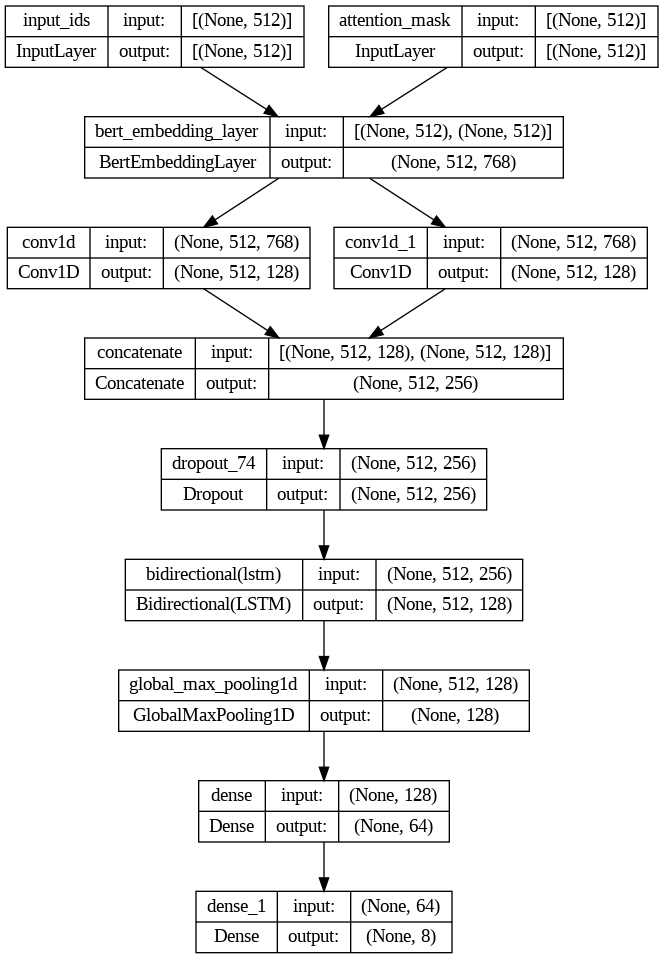

In [ ]:
# @title
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-BiLSTM-CNN_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function


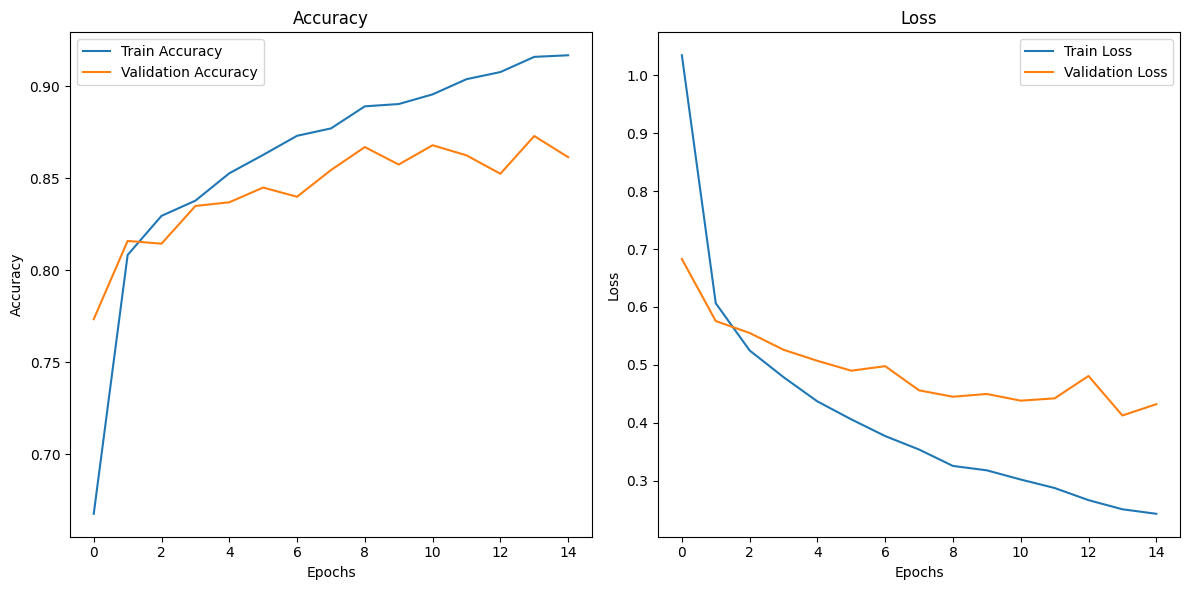

In [ ]:
# @title
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


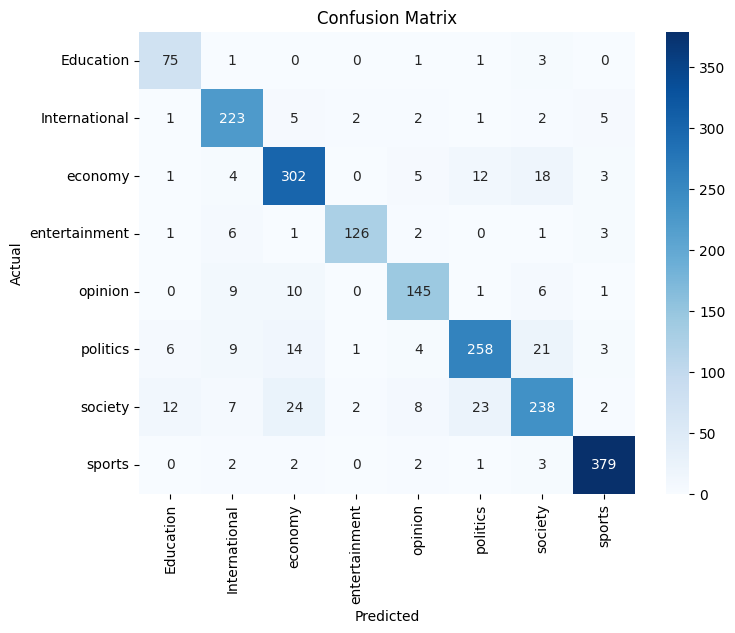

               precision    recall  f1-score   support

    Education       0.78      0.93      0.85        81
International       0.85      0.93      0.89       241
      economy       0.84      0.88      0.86       345
entertainment       0.96      0.90      0.93       140
      opinion       0.86      0.84      0.85       172
     politics       0.87      0.82      0.84       316
      society       0.82      0.75      0.78       316
       sports       0.96      0.97      0.97       389

     accuracy                           0.87      2000
    macro avg       0.87      0.88      0.87      2000
 weighted avg       0.87      0.87      0.87      2000



In [ ]:
# @title
# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_[unique_labels].astype(str), labels=unique_labels)) # Add labels argument

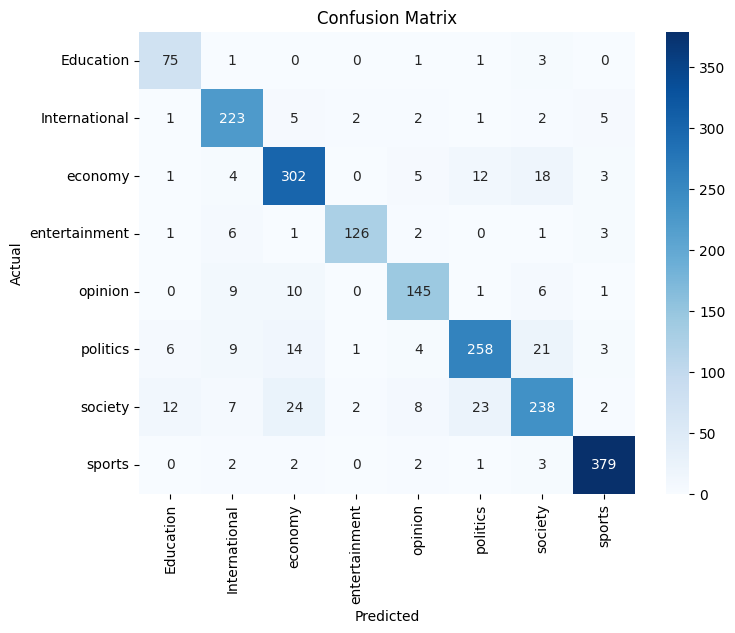

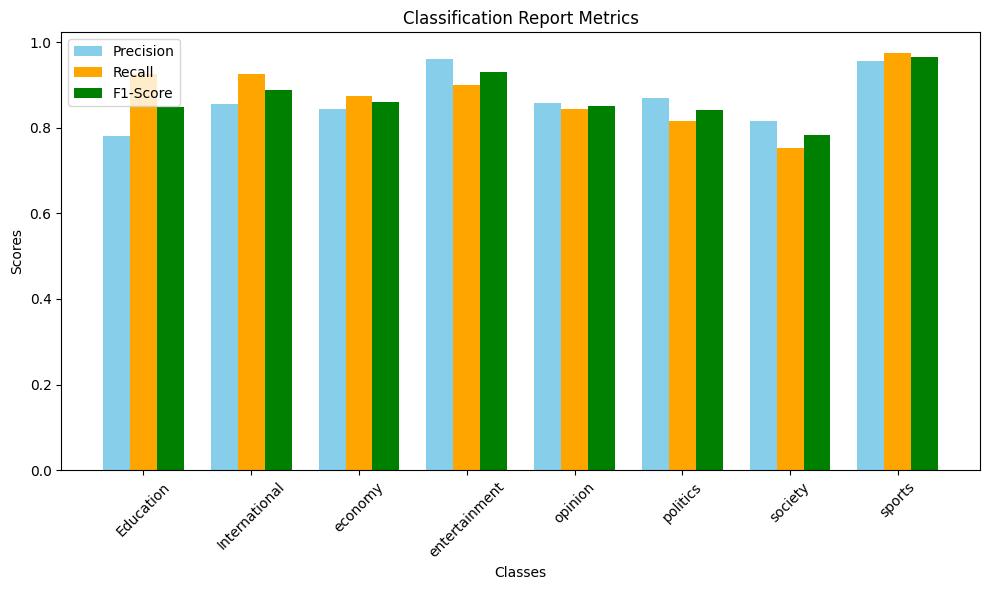

               precision    recall  f1-score   support

    Education       0.78      0.93      0.85        81
International       0.85      0.93      0.89       241
      economy       0.84      0.88      0.86       345
entertainment       0.96      0.90      0.93       140
      opinion       0.86      0.84      0.85       172
     politics       0.87      0.82      0.84       316
      society       0.82      0.75      0.78       316
       sports       0.96      0.97      0.97       389

     accuracy                           0.87      2000
    macro avg       0.87      0.88      0.87      2000
 weighted avg       0.87      0.87      0.87      2000



In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels,
    output_dict=True  # Get the report as a dictionary
)

# Extract metrics for each class
class_names = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[cls]['precision'] for cls in class_names]
recall = [report[cls]['recall'] for cls in class_names]
f1_score = [report[cls]['f1-score'] for cls in class_names]

# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='orange')
plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Print the classification report
print(classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels
))


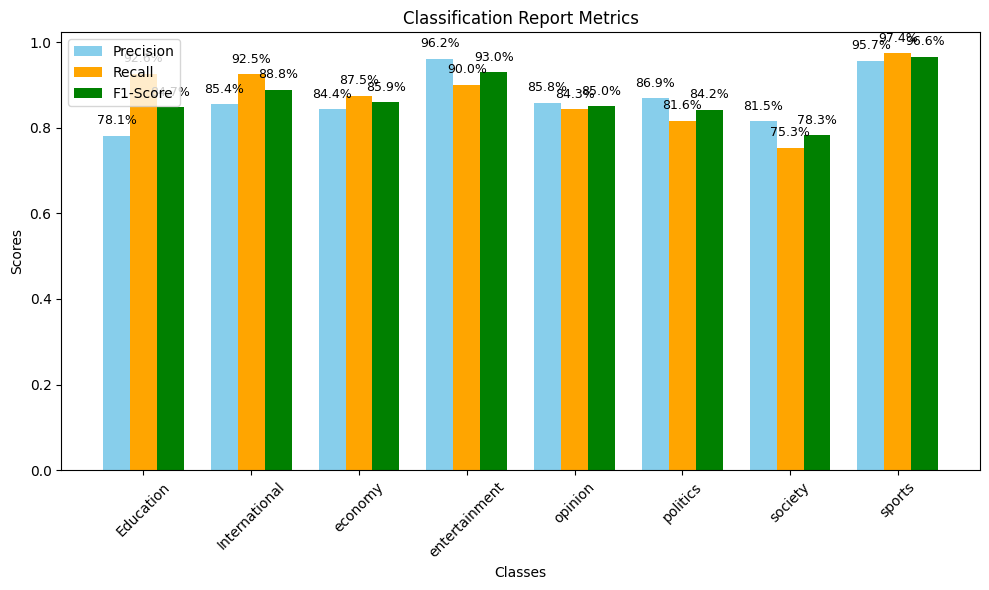

In [ ]:
# @title
# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='orange')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add percentages on top of each bar
for bars, metric in zip([precision_bars, recall_bars, f1_score_bars], [precision, recall, f1_score]):
    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Position: center and slightly above the bar
                 f'{value:.1%}', ha='center', va='bottom', fontsize=9)  # Format as percentage

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


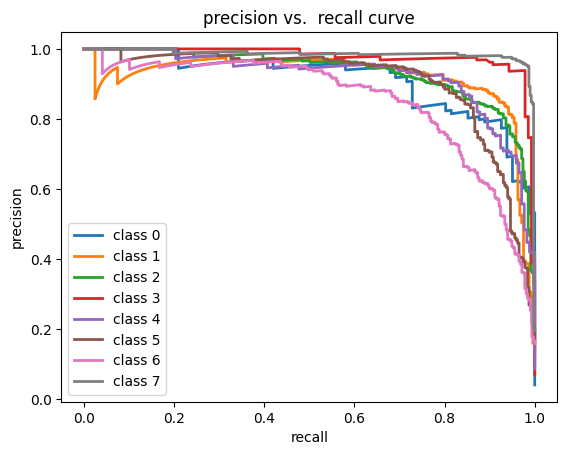

In [ ]:
# @title
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    # Convert y_test to a NumPy array to ensure element-wise comparison
    y_test_array = np.array(y_test)
    precision[i], recall[i], _ = precision_recall_curve((y_test_array == i).astype(int), y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

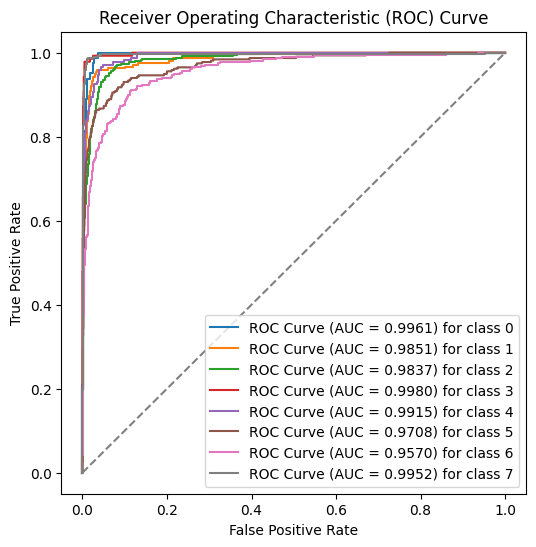

In [ ]:
# @title
# ROC Curve for multiclass classification

# Binarize the output
y_test_binary = label_binarize(y_test, classes=range(num_classes)) # Change here

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

##---

### Traning

In [ ]:
# @title
# Use strategy.scope() for distributed training if needed
strategy = tf.distribute.get_strategy()
with strategy.scope():
    # Build and compile the model within the strategy scope
    model =build_cnn_bilstm_model_with_bert_embeddings(bert_model, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



In [ ]:
# @title
# Train the Model
# # apply early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# # Train the model
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset,callbacks=[early_stopping])
# history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Model using the Dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/15
17325/17325 [==============================] - 1215s 69ms/step - loss: 0.7796 - accuracy: 0.7577 - val_loss: 0.5048 - val_accuracy: 0.8385
Epoch 2/15
17325/17325 [==============================] - 1192s 69ms/step - loss: 0.4889 - accuracy: 0.8419 - val_loss: 0.4337 - val_accuracy: 0.8585
Epoch 3/15
17325/17325 [==============================] - 1191s 69ms/step - loss: 0.4326 - accuracy: 0.8577 - val_loss: 0.4004 - val_accuracy: 0.8668
Epoch 4/15
17325/17325 [==============================] - 1188s 69ms/step - loss: 0.3945 - accuracy: 0.8710 - val_loss: 0.3537 - val_accuracy: 0.8835
Epoch 5/15
17325/17325 [==============================] - 1188s 69ms/step - loss: 0.3660 - accuracy: 0.8783 - val_loss: 0.3442 - val_accuracy: 0.8825
Epoch 6/15
17325/17325 [==============================] - 1188s 69ms/step - loss: 0.3422 - accuracy: 0.8868 - val_loss: 0.3305 - val_accuracy: 0.8937
Epoch 7/15
17325/17325 [==============================] - 1193s 69ms/step - loss: 0.3245 - accuracy:

In [ ]:
# @title
# Train the Model
# # apply early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# # Train the model
history1 = model.fit(train_dataset, epochs=15, validation_data=test_dataset,callbacks=[early_stopping])
# history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

# Evaluate the Model using the Dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/15
2667/2667 [==============================] - 203s 70ms/step - loss: 1.4255 - accuracy: 0.5418 - val_loss: 0.9797 - val_accuracy: 0.7375
Epoch 2/15
2667/2667 [==============================] - 181s 68ms/step - loss: 0.8708 - accuracy: 0.7420 - val_loss: 0.7337 - val_accuracy: 0.7730
Epoch 3/15
2667/2667 [==============================] - 180s 67ms/step - loss: 0.7091 - accuracy: 0.7854 - val_loss: 0.7119 - val_accuracy: 0.7830
Epoch 4/15
2667/2667 [==============================] - 181s 68ms/step - loss: 0.6307 - accuracy: 0.8085 - val_loss: 0.6069 - val_accuracy: 0.8110
Epoch 5/15
2667/2667 [==============================] - 180s 68ms/step - loss: 0.5885 - accuracy: 0.8117 - val_loss: 0.5745 - val_accuracy: 0.8200
Epoch 6/15
2667/2667 [==============================] - 181s 68ms/step - loss: 0.5409 - accuracy: 0.8315 - val_loss: 0.5623 - val_accuracy: 0.8155
Epoch 7/15
2667/2667 [==============================] - 181s 68ms/step - loss: 0.5166 - accuracy: 0.8330 - val_loss: 0

### Visualization 2 CNN 256 k 5,3 drop 0.1 bilstm 128 max, dense 64

In [ ]:
# @title
# model symmary
model.summary()

In [ ]:
# @title
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-BiLSTM-CNN_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function


In [ ]:
# @title
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


In [ ]:
# @title
# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_[unique_labels].astype(str), labels=unique_labels)) # Add labels argument

In [ ]:
# @title
# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='orange')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add percentages on top of each bar
for bars, metric in zip([precision_bars, recall_bars, f1_score_bars], [precision, recall, f1_score]):
    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Position: center and slightly above the bar
                 f'{value:.1%}', ha='center', va='bottom', fontsize=9)  # Format as percentage

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# @title
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    # Convert y_test to a NumPy array to ensure element-wise comparison
    y_test_array = np.array(y_test)
    precision[i], recall[i], _ = precision_recall_curve((y_test_array == i).astype(int), y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

In [ ]:
# @title
# ROC Curve for multiclass classification

# Binarize the output
y_test_binary = label_binarize(y_test, classes=range(num_classes)) # Change here

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Visualization 0

In [ ]:
# @title
# model symmary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_embedding_layer (Bert  (None, 512, 768)             1778534   ['input_ids[0][0]',           
 EmbeddingLayer)                                          40         'attention_mask[0][0]']      
                                                                                              

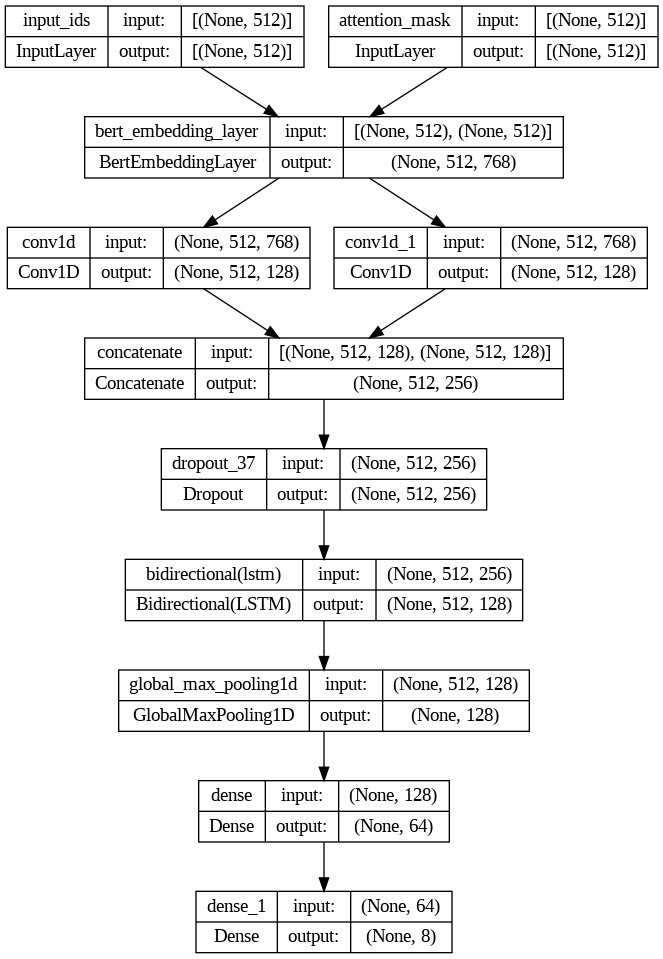

In [ ]:
# @title
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-BiLSTM-CNN_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function


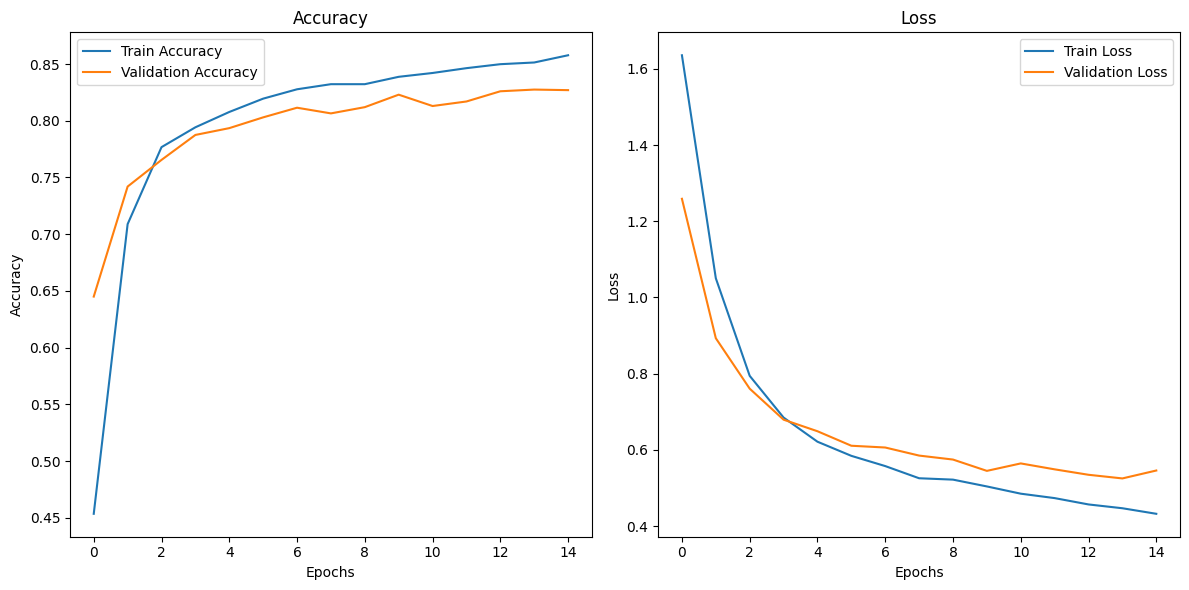

In [ ]:
# @title
# Plot accuracy and loss curves
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


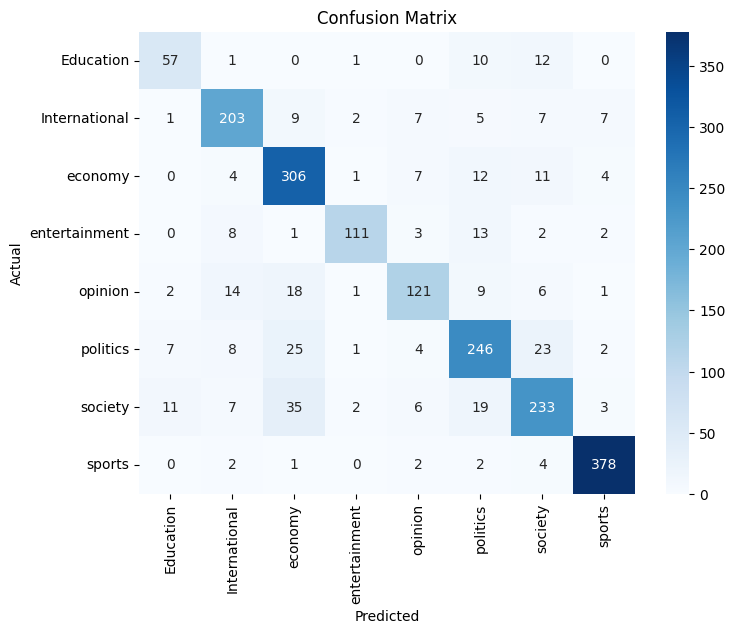

               precision    recall  f1-score   support

    Education       0.73      0.70      0.72        81
International       0.82      0.84      0.83       241
      economy       0.77      0.89      0.83       345
entertainment       0.93      0.79      0.86       140
      opinion       0.81      0.70      0.75       172
     politics       0.78      0.78      0.78       316
      society       0.78      0.74      0.76       316
       sports       0.95      0.97      0.96       389

     accuracy                           0.83      2000
    macro avg       0.82      0.80      0.81      2000
 weighted avg       0.83      0.83      0.83      2000



In [ ]:
# @title
# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_[unique_labels].astype(str), labels=unique_labels)) # Add labels argument

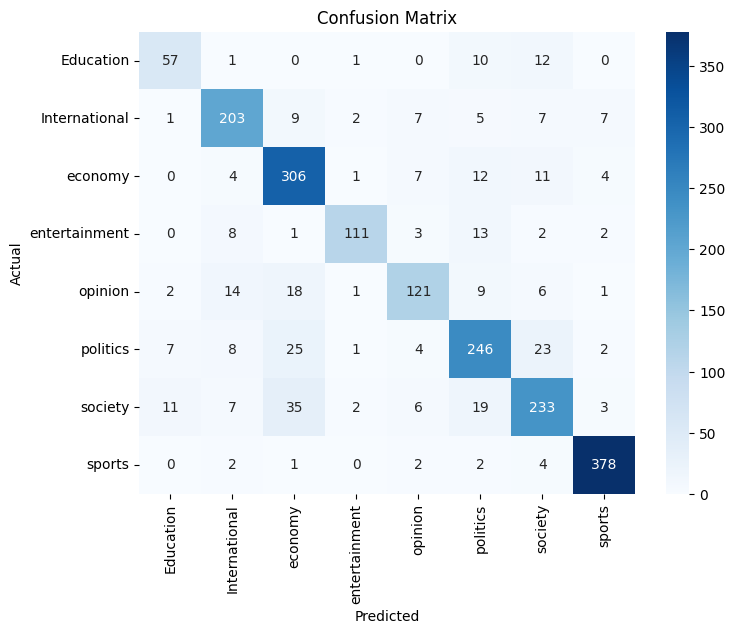

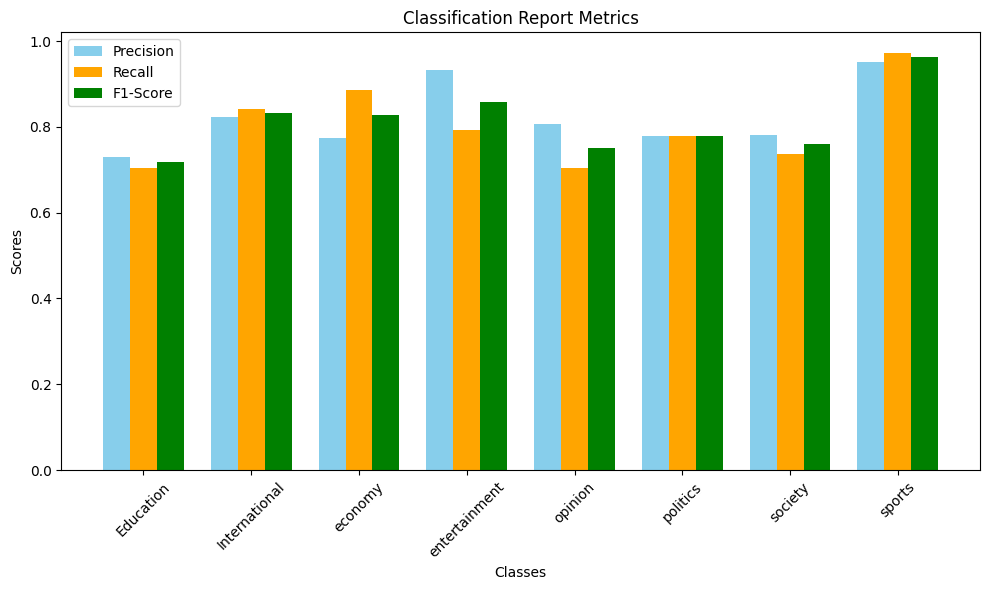

               precision    recall  f1-score   support

    Education       0.73      0.70      0.72        81
International       0.82      0.84      0.83       241
      economy       0.77      0.89      0.83       345
entertainment       0.93      0.79      0.86       140
      opinion       0.81      0.70      0.75       172
     politics       0.78      0.78      0.78       316
      society       0.78      0.74      0.76       316
       sports       0.95      0.97      0.96       389

     accuracy                           0.83      2000
    macro avg       0.82      0.80      0.81      2000
 weighted avg       0.83      0.83      0.83      2000



In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels,
    output_dict=True  # Get the report as a dictionary
)

# Extract metrics for each class
class_names = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[cls]['precision'] for cls in class_names]
recall = [report[cls]['recall'] for cls in class_names]
f1_score = [report[cls]['f1-score'] for cls in class_names]

# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='orange')
plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Print the classification report
print(classification_report(
    y_test, y_pred_labels,
    target_names=label_encoder.classes_[unique_labels].astype(str),
    labels=unique_labels
))


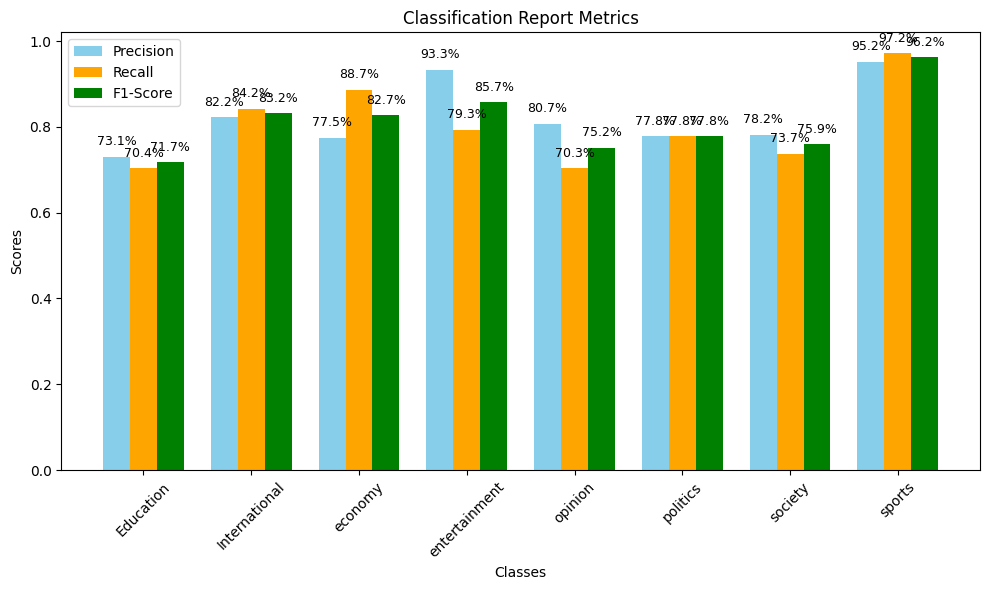

In [ ]:
# @title
# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='orange')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add percentages on top of each bar
for bars, metric in zip([precision_bars, recall_bars, f1_score_bars], [precision, recall, f1_score]):
    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Position: center and slightly above the bar
                 f'{value:.1%}', ha='center', va='bottom', fontsize=9)  # Format as percentage

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


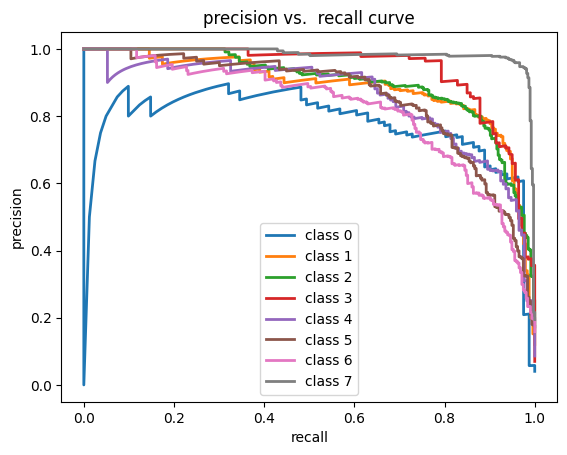

In [ ]:
# @title
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    # Convert y_test to a NumPy array to ensure element-wise comparison
    y_test_array = np.array(y_test)
    precision[i], recall[i], _ = precision_recall_curve((y_test_array == i).astype(int), y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

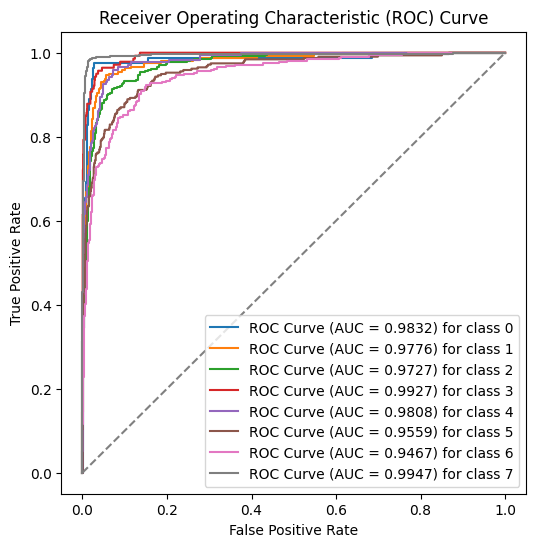

In [ ]:
# @title
# ROC Curve for multiclass classification

# Binarize the output
y_test_binary = label_binarize(y_test, classes=range(num_classes)) # Change here

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Save model

In [ ]:
# @title
import tensorflow as tf

# Save the model in the SavedModel format
model.save("saved_model_directory")


NameError: name 'model' is not defined

In [ ]:
import pickle

# Assuming `history` is the History object returned by `model.fit`
with open("training_history.pkl", "wb") as file:
    pickle.dump(history.history, file)


NameError: name 'history' is not defined

#### Saved Model Loading

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
# @title
import tensorflow as tf
from transformers import AutoTokenizer
import numpy as np

# Save the tokenizer
def save_tokenizer():
    # Initialize tokenizer (update to match your original tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
    tokenizer.save_pretrained("saved_model_directory")  # Save tokenizer to the directory

# Load the model and tokenizer, and predict the category of input text
def predict_category(input_text):
    # Load the saved model
    loaded_model = tf.keras.models.load_model("saved_model_directory")

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("saved_model_directory")

    # Tokenize the input text
    encoded_input = tokenizer(
        input_text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

    # Predict using the model
    predictions = loaded_model.predict({
        "input_ids": encoded_input["input_ids"],
        "attention_mask": encoded_input["attention_mask"]
    })

    # Get the predicted category
    predicted_category = np.argmax(predictions, axis=1)
    return predicted_category[0]

# Main execution
if __name__ == "__main__":
    # Save the tokenizer (only required once)
    save_tokenizer()

    # Input text
    input_text = '''नेपालमा लोक सेवा आयोगले लिने परीक्षामा सहभागीको सङ्ख्या हेर्दा निकै आकर्षण भए जस्तो देखिन्छ। निकै प्रतिस्पर्धा देखिन्छ। यत्रो प्रतिस्पर्धा भएपछि निकै काबिल व्यक्ति छानिन्छन् होला जस्तो लाग्छ। तर वास्तविकता भने त्यस्तो पाइँदैन।

लोक सेवा आयोगको आर्थिक वर्ष २०८०/८१ को वार्षिक प्रतिवेदनअनुसार निजामती सेवाको खुला र समावेशी विभिन्न तहका पदमा १ हजार ९ सय ८० जनाको लागि विज्ञापन खुल्यो। त्यसमा ४ लाख ८३ हजार ४ सय ९० जनाले दरखास्त दिए।

निजामती सेवामा अधिकांश पद विशेष सीप, ज्ञान र क्षमता नभएका व्यक्तिका लागि हुन्छन्। त्यसमा धेरै दरखास्त पर्दछ। विशेष ज्ञान, सीप र योग्यता चाहिने पदमा उम्मेदवारी नै नपरेको समेत पाइन्छ। उम्मेदवारी परेकोमा पनि प्रतिस्पर्धा न्यून हुन्छ। गत वर्ष २४ वटा विज्ञापनमा कुनै दरखास्त नै परेन।

लोक सेवामा कसको भीड?

लोक सेवा आयोगको परीक्षामा अधिकांशतम मध्यम र कमजोर व्यक्तिहरूको भीड लागेको पाइन्छ। खरिदार पदमा माध्यमिक तहको गणित र विज्ञान पाठ्यक्रममा समावेश गरिएको छ। यसमा न्यून उम्मेदवारी पर्दछ। नायव सुब्बा र अधिकृत तहमा पाठ्यक्रम सजिलो भएको कारण भीड लागेको हो। ना.सु र अधिकृतमा यति कमजोर व्यक्ति प्रतिस्पर्धा गर्दछन्, जो खरिदारका लागि आफूलाई योग्य ठान्दैनन्। जस्तो सुकै कमजोर व्यक्तिले पनि कण्ठ पारेर यो परीक्षा पास गर्छु भनेर आस गर्न सक्छ।

निजामतीमा पुरुषका लागि ३५ र महिलाका लागि ४० वर्षको उमेर हद छ। सहायक तहमा १८ र अधिकृत तहमा २१ वर्ष पुगेपछि परीक्षा दिन पाइन्छ। २५ वर्षदेखि ३५ वर्षसम्म परीक्षा दिइरहेका पुरुषको सङ्ख्या उल्लेख्य देखिन्छ। ४० वर्षसम्म परीक्षा दिइरहने महिला झन् धेरै देखिन्छ।'''

    # Predict the category of the input text
    category = predict_category(input_text)
    print(f"Predicted Category: {category}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

1/1 [==============================] - 3s 3s/step
Predicted Category: 4


In [ ]:
# @title
import tensorflow as tf
from transformers import AutoTokenizer
import numpy as np

# Save the tokenizer
def save_tokenizer():
    # Initialize tokenizer (update to match your original tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
    tokenizer.save_pretrained("saved_model_directory")  # Save tokenizer to the directory

# Load the model and tokenizer, and predict the category of input text
def predict_category(input_text, threshold=0.5):
    # Load the saved model
    loaded_model = tf.keras.models.load_model("saved_model_directory")

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("saved_model_directory")

    # Tokenize the input text
    encoded_input = tokenizer(
        input_text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

    # Predict using the model
    predictions = loaded_model.predict({
        "input_ids": encoded_input["input_ids"],
        "attention_mask": encoded_input["attention_mask"]
    })

    # Get the probabilities and the predicted category
    probabilities = tf.nn.softmax(predictions, axis=1).numpy()
    max_probability = np.max(probabilities, axis=1)
    predicted_category = np.argmax(probabilities, axis=1)

    # Check if the maximum probability is below the threshold
    if max_probability[0] < threshold:
        return "Not belonging to any class"
    else:
        return predicted_category[0]

# Main execution
if __name__ == "__main__":
    # Save the tokenizer (only required once)
    save_tokenizer()

    # Input text
    input_text = '''नेपालमा लोक सेवा आयोगले लिने परीक्षामा सहभागीको सङ्ख्या हेर्दा निकै आकर्षण भए जस्तो देखिन्छ। निकै प्रतिस्पर्धा देखिन्छ। यत्रो प्रतिस्पर्धा भएपछि निकै काबिल व्यक्ति छानिन्छन् होला जस्तो लाग्छ। तर वास्तविकता भने त्यस्तो पाइँदैन।

लोक सेवा आयोगको आर्थिक वर्ष २०८०/८१ को वार्षिक प्रतिवेदनअनुसार निजामती सेवाको खुला र समावेशी विभिन्न तहका पदमा १ हजार ९ सय ८० जनाको लागि विज्ञापन खुल्यो। त्यसमा ४ लाख ८३ हजार ४ सय ९० जनाले दरखास्त दिए।

निजामती सेवामा अधिकांश पद विशेष सीप, ज्ञान र क्षमता नभएका व्यक्तिका लागि हुन्छन्। त्यसमा धेरै दरखास्त पर्दछ। विशेष ज्ञान, सीप र योग्यता चाहिने पदमा उम्मेदवारी नै नपरेको समेत पाइन्छ। उम्मेदवारी परेकोमा पनि प्रतिस्पर्धा न्यून हुन्छ। गत वर्ष २४ वटा विज्ञापनमा कुनै दरखास्त नै परेन।

लोक सेवामा कसको भीड?

लोक सेवा आयोगको परीक्षामा अधिकांशतम मध्यम र कमजोर व्यक्तिहरूको भीड लागेको पाइन्छ। खरिदार पदमा माध्यमिक तहको गणित र विज्ञान पाठ्यक्रममा समावेश गरिएको छ। यसमा न्यून उम्मेदवारी पर्दछ। नायव सुब्बा र अधिकृत तहमा पाठ्यक्रम सजिलो भएको कारण भीड लागेको हो। ना.सु र अधिकृतमा यति कमजोर व्यक्ति प्रतिस्पर्धा गर्दछन्, जो खरिदारका लागि आफूलाई योग्य ठान्दैनन्। जस्तो सुकै कमजोर व्यक्तिले पनि कण्ठ पारेर यो परीक्षा पास गर्छु भनेर आस गर्न सक्छ।

निजामतीमा पुरुषका लागि ३५ र महिलाका लागि ४० वर्षको उमेर हद छ। सहायक तहमा १८ र अधिकृत तहमा २१ वर्ष पुगेपछि परीक्षा दिन पाइन्छ। २५ वर्षदेखि ३५ वर्षसम्म परीक्षा दिइरहेका पुरुषको सङ्ख्या उल्लेख्य देखिन्छ। ४० वर्षसम्म परीक्षा दिइरहने महिला झन् धेरै देखिन्छ।'''

    # Predict the category of the input text
    category = predict_category(input_text, threshold=0.5)
    print(f"Predicted Category: {category}")


1/1 [==============================] - 5s 5s/step
Predicted Category: Not belonging to any class


In [ ]:
from scipy.spatial.distance import euclidean

# Example sentences
sentence1 = ["बिना ताल काे संगीत बजिरहेकाे छ।"]
sentence2 = ["बिना माछाकाे ताल छ ।"]

# Tokenize and pad sentences
input_ids_1, attention_mask_1 = tokenize_and_pad(sentence1, tokenizer)
input_ids_2, attention_mask_2 = tokenize_and_pad(sentence2, tokenizer)

# Get tokenized word list for each sentence
tokens_1 = tokenizer.convert_ids_to_tokens(input_ids_1[0])
tokens_2 = tokenizer.convert_ids_to_tokens(input_ids_2[0])

# Find index of the word "ताल" in each tokenized sentence
index_1 = tokens_1.index("ताल")
index_2 = tokens_2.index("ताल")

# Extract contextual embeddings using BertEmbeddingLayer
embedding_1 = bert_embedding_layer([input_ids_1, attention_mask_1])
embedding_2 = bert_embedding_layer([input_ids_2, attention_mask_2])

# Extract embeddings for the word "ताल" using its index
word_embedding_1 = embedding_1[0, index_1, :]  # Shape: (hidden_size,)
word_embedding_2 = embedding_2[0, index_2, :]  # Shape: (hidden_size,)

# Calculate Euclidean distance
distance = euclidean(word_embedding_1.numpy(), word_embedding_2.numpy())

print(f"Euclidean distance for 'ताल' between the two sentences: {distance:.4f}")


### Visualization 2

In [ ]:
# @title
# model symmary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_embedding_layer_1 (Be  (None, 512, 768)             1778534   ['input_ids[0][0]',           
 rtEmbeddingLayer)                                        40         'attention_mask[0][0]']      
                                                                                            

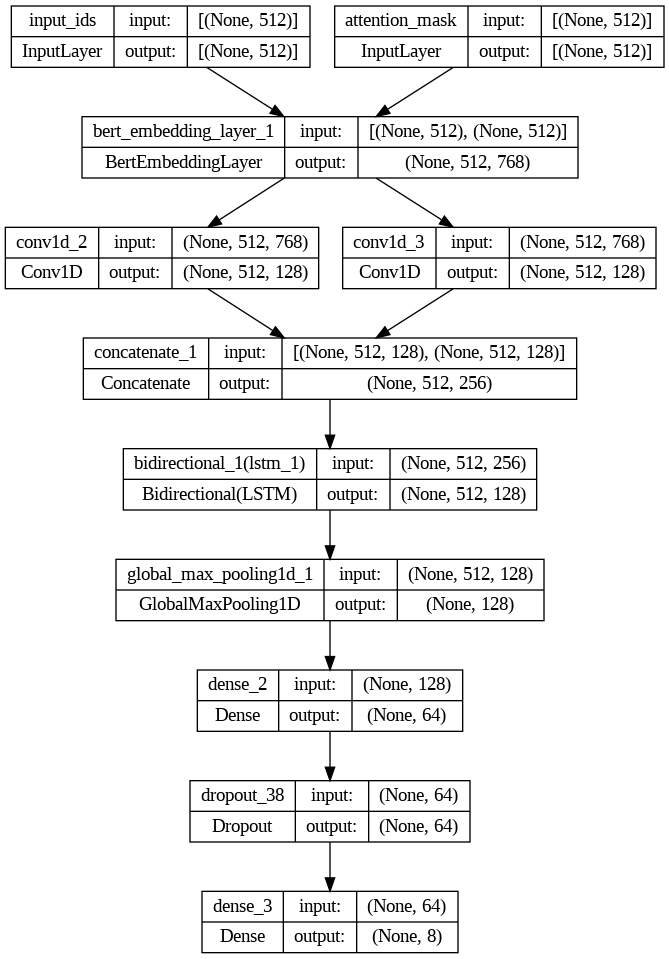

In [ ]:
# @title
# Plot the model architecture and save to the specified file
tf.keras.utils.plot_model(model, to_file='BER-BiLSTM-CNN_model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize # import the label_binarize function


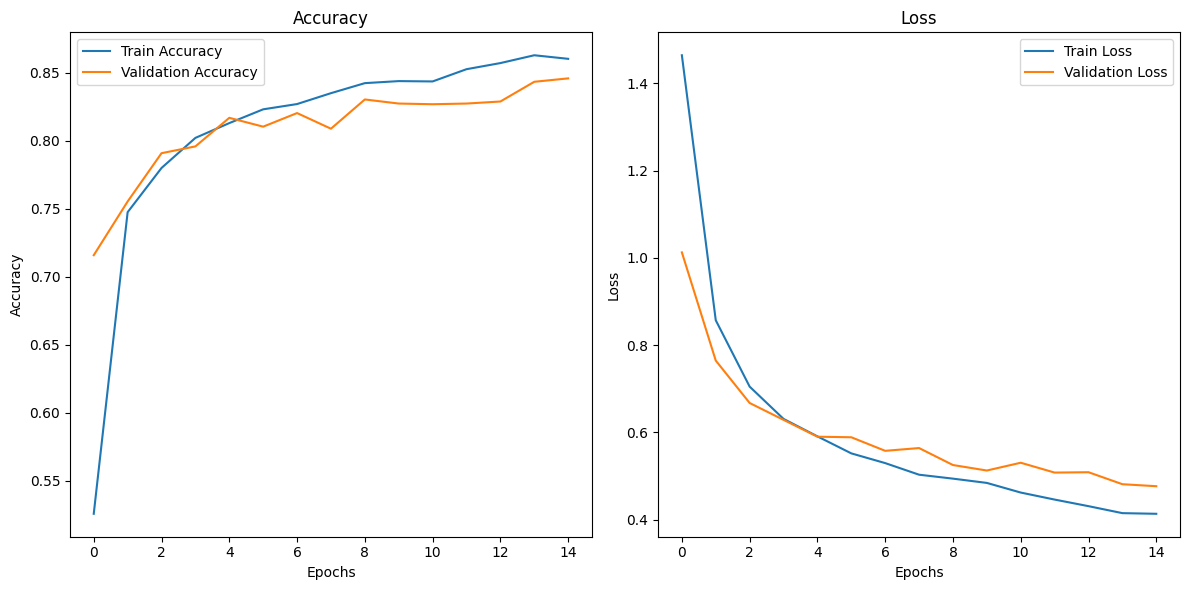

In [ ]:
# @title
# Plot accuracy and loss curves
def plot_training_history(history1):
    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history1)


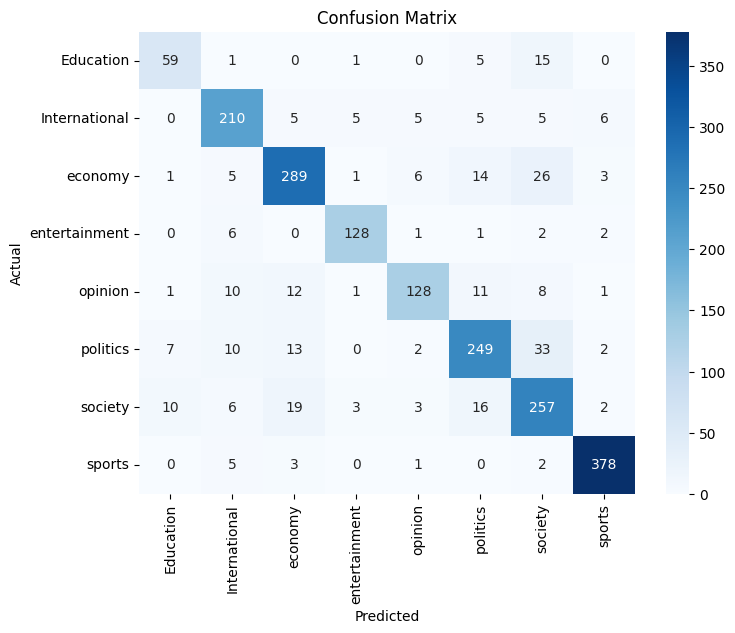

               precision    recall  f1-score   support

    Education       0.76      0.73      0.74        81
International       0.83      0.87      0.85       241
      economy       0.85      0.84      0.84       345
entertainment       0.92      0.91      0.92       140
      opinion       0.88      0.74      0.81       172
     politics       0.83      0.79      0.81       316
      society       0.74      0.81      0.77       316
       sports       0.96      0.97      0.97       389

     accuracy                           0.85      2000
    macro avg       0.84      0.83      0.84      2000
 weighted avg       0.85      0.85      0.85      2000



In [ ]:
# @title
# Predictions and true labels
# y_pred = model.predict(test_dataset)
# y_pred_labels = np.argmax(y_pred, axis=1)

# Get unique labels in y_test and y_pred_labels
unique_labels = np.unique(np.concatenate((y_test, y_pred_labels)))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=unique_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_[unique_labels].astype(str), # Use unique labels for target names
            yticklabels=label_encoder.classes_[unique_labels].astype(str))  # Use unique labels for target names
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_[unique_labels].astype(str), labels=unique_labels)) # Add labels argument

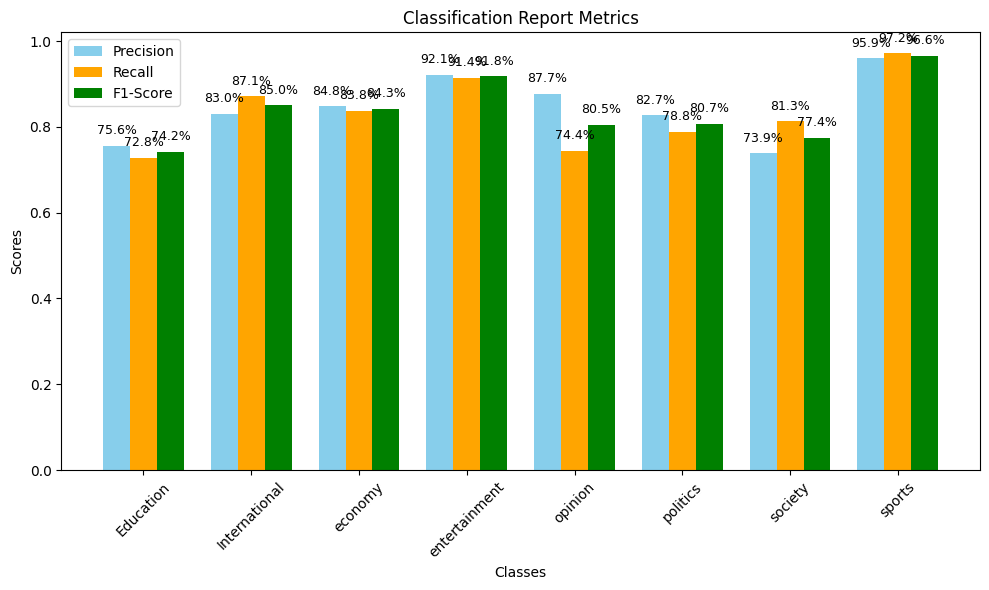

In [ ]:
# @title
# Create a bar plot for Precision, Recall, and F1-Score
x = np.arange(len(class_names))  # Label positions
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
precision_bars = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
recall_bars = plt.bar(x, recall, width, label='Recall', color='orange')
f1_score_bars = plt.bar(x + width, f1_score, width, label='F1-Score', color='green')

# Add percentages on top of each bar
for bars, metric in zip([precision_bars, recall_bars, f1_score_bars], [precision, recall, f1_score]):
    for bar, value in zip(bars, metric):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Position: center and slightly above the bar
                 f'{value:.1%}', ha='center', va='bottom', fontsize=9)  # Format as percentage

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


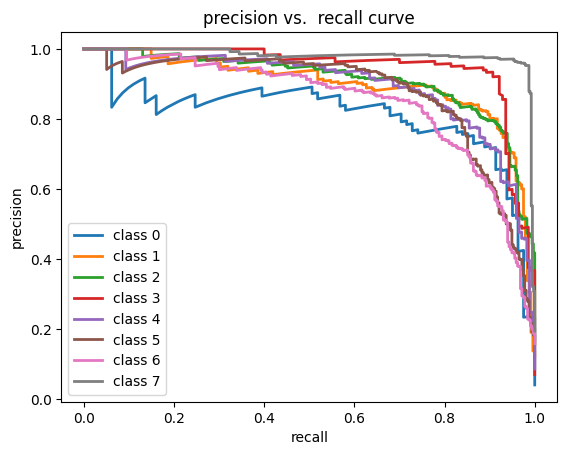

In [ ]:
# @title
# Precision-Recall Curve for Multiclass Classification

# Iterate over each class
precision = dict()
recall = dict()
for i in range(num_classes): # num_classes is the number of classes in your dataset
    # Convert y_test to a NumPy array to ensure element-wise comparison
    y_test_array = np.array(y_test)
    precision[i], recall[i], _ = precision_recall_curve((y_test_array == i).astype(int), y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs.  recall curve")
plt.show()

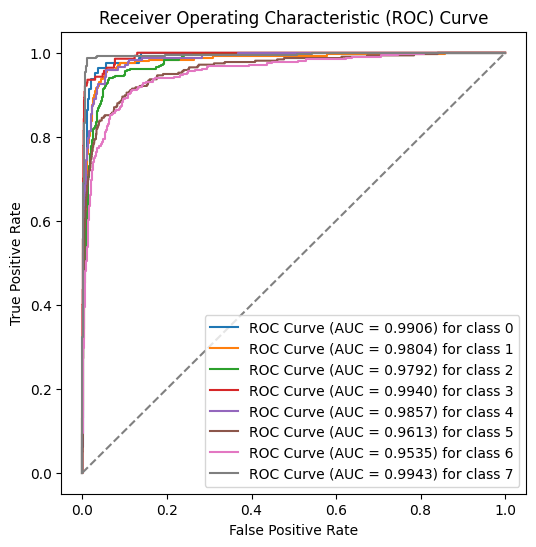

In [ ]:
# @title
# ROC Curve for multiclass classification

# Binarize the output
y_test_binary = label_binarize(y_test, classes=range(num_classes)) # Change here

# Iterate over each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=plt.cm.tab10(i),
             label=f'ROC Curve (AUC = {roc_auc[i]:.4f}) for class {i}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### ///////////////